# Plot Land-Based Loadings

Builds a plot showing the loadings from rivers and point sources, using either the Excel converted model input file (set `ssm_pnt_type` to `excel`) or a raw dat file (set it to `dat`).

In [1]:
ssm_pnt_file = '/home/benr/wqmodels/ssm/ecology_inputs_phase2/2014/2014_Exist_ssm_pnt_wq.dat'
ssm_pnt_type = 'dat'
start_date = '2014-01-01'
source_name = 'Ecology SSM 2014 input file'
ssm_grid_file = '../SSM_Grid/ssm_grid.2dm'

# What loadings to examine. Use None to just look at flows.
constituents_label = 'DIN'
constituents = ['no32','nh4']
#constituents = None

# Use this to load a hydrodynamic dat file
#num_statevars = 3
num_statevars = None

import os.path as path
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.collections import PathCollection
from shapely.geometry import Point
import contextily as cx
from adjustText import adjust_text
sys.path.append('..')
from apis import API_KEYS

from fvcom.grid import FvcomGrid
from ssm_write_fwinputs import read_data
from ssm_read_fwinputs import read_dat_file

Initialize some helper objects, the grid and the data file

In [2]:
grid = FvcomGrid.from_mesh(ssm_grid_file)
if ssm_pnt_type == 'excel':
    pnt_data = read_data(ssm_pnt_file)
else:
    with open(ssm_pnt_file) as f:
        pnt_data, *junk = read_dat_file(f, pd.Timestamp(start_date), num_statevars=num_statevars)
pnt_data['nodes'].head()

,,Node,Comment,FVCOM ID,Dist Nodes,Dist Type,Name,Source Type,Region,Country
Node,FVCOM ID,,,,,,,,,
15634,301,15634,"FVCOM ID/Node: 301 / 15634, nodes/distribution...",301,1,Surface3,Agate East,River,South_Sound,United States
15936,302,15936,"FVCOM ID/Node: 302 / 15936, nodes/distribution...",302,1,Surface3,Agate West,River,South_Sound,United States
14437,303,14437,"FVCOM ID/Node: 303 / 14437, nodes/distribution...",303,1,Surface3,Anderson east,River,South_Sound,United States
14689,304,14689,"FVCOM ID/Node: 304 / 14689, nodes/distribution...",304,1,Surface3,Anderson west,River,South_Sound,United States
14177,305,14177,"FVCOM ID/Node: 305 / 14177, nodes/distribution...",305,1,Surface3,Artondale,River,South_Sound,United States


Rivers are tricky because some of them have the discharges spread over two adjacent nodes. To handle this, check if the next node is adjacent the current one and, if so, assume it's part of the same river.

During the iteration, match up labels and coordinates. Rivers spread over multiple nodes get coordinates that are the mean location of the two nodes.

In [3]:
all_neis = grid.node_neis()
grid_nodes = grid.nodes_gdf()
srcids = []
data_by_src = []
names = []
types = []
geoms = []
if constituents is None:
    constituents_label = 'Discharge'
    unit = "m3/d"
else:
    unit = "kg/d"
for i,grp in pnt_data['nodes'].groupby(level=1):
    srcids.append(i)
    names.append(grp['Name'].iloc[0])
    types.append(grp['Source Type'].iloc[0])
    if len(grp) > 1:
        # Multiple nodes, compute middle
        geoms.append(grid_nodes.loc[grp.index.get_level_values(0)].dissolve().centroid.iloc[0])
    else:
        geoms.append(grid_nodes.loc[grp.index.get_level_values(0), 'geometry'].iloc[0])
    # Now aggregate the loading data
    data = pnt_data['data'].xs(i, level=2).groupby(level=1).head()
    if constituents is not None:
        data_by_src.append((data['discharge'] * data[constituents].sum(axis='columns')).mean() * 86.4)
    else:
        data_by_src.append(data['discharge'].mean() * 86.4)
src_df = gpd.GeoDataFrame({'Name': names, 'Type': types, 'Loading': data_by_src},
                          geometry=geoms, index=srcids, crs='epsg:32610')
src_df.head()

,Name,Type,Loading,geometry
301,Agate East,River,14.567154,POINT (502538 5227964)
302,Agate West,River,2.729105,POINT (495879 5228107)
303,Anderson east,River,2.018364,POINT (523677 5225599)
304,Anderson west,River,6.224488,POINT (523299 5221263)
305,Artondale,River,10.475773,POINT (530252 5236968)


In [4]:
rivers = src_df.loc[src_df['Type'] == 'River'].copy()
pntsrcs = src_df.loc[src_df['Type'] == 'Point Source'].copy()

Assemble the plot

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


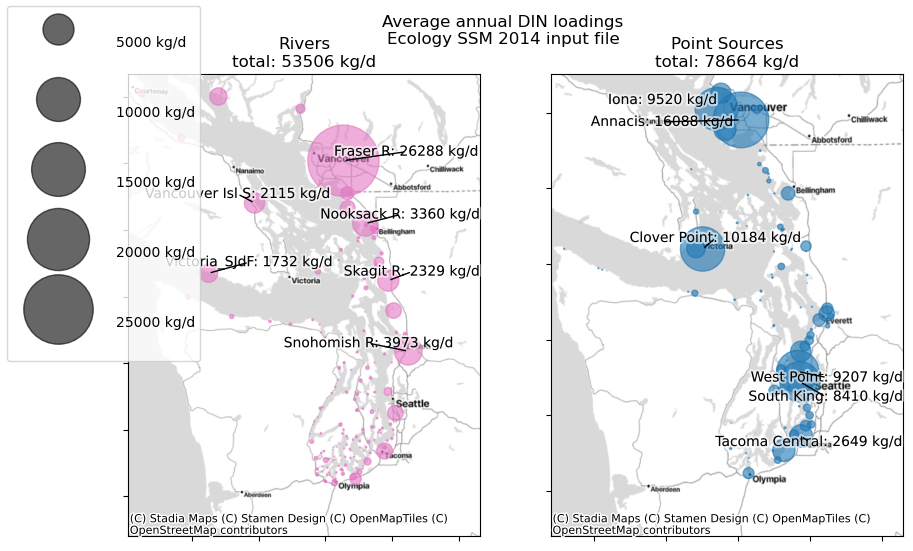

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))

def do_plot(ax, gdf, color, title):
    scatter = ax.scatter(gdf['geometry'].x, gdf['geometry'].y,
                         alpha=0.6, color=color, s=gdf['Loading']/10)
    xmin, xmax, ymin, ymax = ax.axis()
    ax.set(title=f"{title}\ntotal: {gdf['Loading'].sum():.0f} {unit}",
           xbound=(xmin, xmax + 0.2 * (xmax - xmin)),
           ybound=(5170000, None), xticklabels=(), yticklabels=()
          )
    top6 = gdf.sort_values('Loading', ascending=False).iloc[:6]
    gdf.loc[top6.index, 'Label'] = top6['Name']
    texts = []
    for i,row in gdf.dropna(subset='Label').iterrows():
        texts.append(
            ax.annotate(f"{row['Label']}: {row['Loading']:.0f} {unit}",
                        xy=(row['geometry'].x, row['geometry'].y),
                        ha='center', va='center', path_effects=[
                            pe.withStroke(linewidth=3, foreground='white',
                                          alpha=0.6)
                        ]))
    adjust_text(texts, gdf['geometry'].x.to_numpy(), gdf['geometry'].y.to_numpy(),
                force_points=(0.4, 1),
                ax=ax, arrowprops=dict(arrowstyle='-'))
    tileset = cx.providers.Stadia.StamenTonerLite
    tileset['url'] = 'https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=' + API_KEYS['stadia']
    cx.add_basemap(ax, crs=gdf.crs, source=tileset)
    return scatter, top6.index

rivers_coll, top_rivers = do_plot(axs[0], rivers, 'tab:pink', 'Rivers')
pntsrcs_coll, top_pntsrcs = do_plot(axs[1], pntsrcs, 'tab:blue', 'Point Sources')
# See https://stackoverflow.com/a/76212772/413862
all_scatters = PathCollection(rivers_coll.get_paths() + pntsrcs_coll.get_paths(),
                              np.concatenate((rivers_coll.get_sizes(),
                                              pntsrcs_coll.get_sizes()))
                             )
handles, labels = all_scatters.legend_elements(prop="sizes", num=6, alpha=0.6,
                                               func=lambda s: s * 10,
                                               fmt='{x:.0f} %s' % unit)
legend_rows = np.sqrt(max(rivers['Loading'].max(),
                              pntsrcs['Loading'].max()) / 600)
fig.legend(handles, labels, loc='upper left',
           handlelength=legend_rows, handleheight=legend_rows
          )

fig.suptitle(f"Average annual {constituents_label} loadings\n{source_name}")

run_name = '.'.join(path.basename(ssm_pnt_file).split('.')[:-1])
fig.savefig(f"notebook_outs/loadings_{run_name}_{constituents_label}.png")
with pd.ExcelWriter(f"notebook_outs/loadings_{run_name}_{constituents_label}.xlsx") as writer:
    rivers.to_excel(writer, sheet_name='Rivers')
    pntsrcs.to_excel(writer, sheet_name='Point Sources')

Plot timeseries of the loadings from the top 6 sources

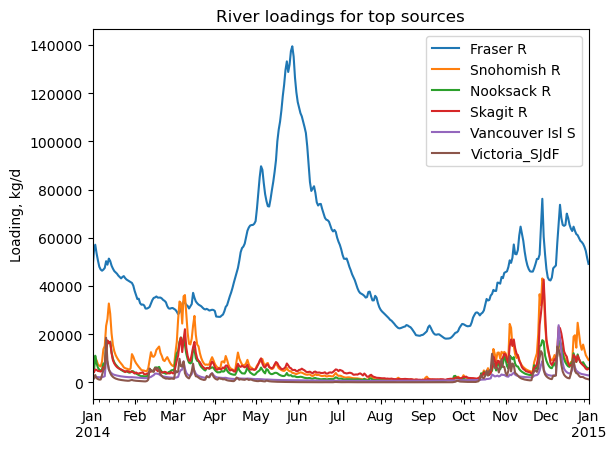

In [6]:
fig, ax = plt.subplots()
loading_ts_rivers = {}
for r in top_rivers:
    if constituents is not None:
        data = pd.Series(
            {d: (group['discharge'] * group[constituents].sum(axis='columns')).sum() * 86.4 for d,group in pnt_data['data'].xs(r, level=2).groupby(level=0)}
        )
    else:
        data = pd.Series(
            {d: group['discharge'].sum() * 86.4 for d,group in pnt_data['data'].xs(r, level=2).groupby(level=0)}
        )
    data.plot(ax=ax, label=rivers.loc[r, 'Name'])
    loading_ts_rivers[rivers.loc[r, 'Name']] = data
loading_ts_rivers = pd.DataFrame(loading_ts_rivers)
ax.set(title='River loadings for top sources', ylabel=f'Loading, {unit}')
ax.legend()
fig.savefig(f"notebook_outs/loadings_riverts_{run_name}_{constituents_label}.png")

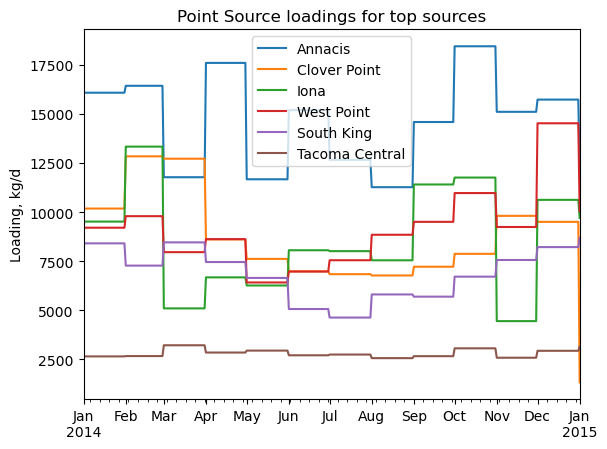

In [7]:
fig, ax = plt.subplots()
loading_ts_pntsrcs = {}
for r in top_pntsrcs:
    if constituents is not None:
        data = pd.Series(
            {d: (group['discharge'] * group[constituents].sum(axis='columns')).sum() * 86.4 for d,group in pnt_data['data'].xs(r, level=2).groupby(level=0)}
        )
    else:
        data = pd.Series(
            {d: group['discharge'].sum() * 86.4 for d,group in pnt_data['data'].xs(r, level=2).groupby(level=0)}
        )
    data.plot(ax=ax, label=pntsrcs.loc[r, 'Name'])
    loading_ts_pntsrcs[pntsrcs.loc[r, 'Name']] = data
loading_ts_pntsrcs = pd.DataFrame(loading_ts_pntsrcs)
ax.set(title='Point Source loadings for top sources', ylabel=f'Loading, {unit}')
ax.legend()
fig.savefig(f"notebook_outs/loadings_pntsrcts_{run_name}_{constituents_label}.png")

In [8]:
with pd.ExcelWriter(f"notebook_outs/loadings_ts_{run_name}_{constituents_label}.xlsx") as writer:
    loading_ts_rivers.to_excel(writer, sheet_name='Rivers')
    loading_ts_pntsrcs.to_excel(writer, sheet_name='Point Sources')